In [34]:
import pybamm
import numpy as np
import pandas as pd    # needed to read the csv data file
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
#from scipy.fftpack import fft fftfreq 
# Import drive cycle from file
drive_cycle = pd.read_csv("output.csv", comment="#", header=None).to_numpy()


# fig, axs = plt.subplots(2, 1)
# axs[0].plot(drive_cycle[:, 0], drive_cycle[:, 1])
# #axs[0].set_xlim(0, 2)
# axs[0].set_xlabel('time')
# axs[0].set_ylabel('current (A)')
# axs[0].grid(True)

# axs[1].plot(drive_cycle[:, 0], drive_cycle[:, 2])
# #cxy, f = axs[1].cohere(s1, s2, 256, 1. / dt)
# axs[1].set_ylabel('Voltage (V)')

# fig.tight_layout()
# plt.show()


#model = pybamm.lithium_ion.SPMe()
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
#parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Ai2020)

# Create interpolant
timescale = parameter_values.evaluate(model.timescale)
current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], -drive_cycle[:, 1], timescale * pybamm.t,interpolator="linear")


# c_n_init = self.parameter_values[
#     "Initial concentration in negative electrode [mol.m-3]"
# ]
# c_p_init = self.parameter_values[
#     "Initial concentration in positive electrode [mol.m-3]"
# ]
# param = pybamm.LithiumIonParameters()
# c_n_max = self.parameter_values.evaluate(param.c_n_max)
# c_p_max = self.parameter_values.evaluate(param.c_p_max)
# x, y = pybamm.lithium_ion.get_initial_stoichiometries(
#     initial_soc, self.parameter_values
# )
# self.parameter_values.update(
#     {
#         "Initial concentration in negative electrode [mol.m-3]": x
#         * c_n_max,
#         "Initial concentration in positive electrode [mol.m-3]": y
#         * c_p_max,
#     }
# )
initial_soc=0.5
c_n_init = parameter_values[
    "Initial concentration in negative electrode [mol.m-3]"
]
c_p_init = parameter_values[
    "Initial concentration in positive electrode [mol.m-3]"
]
param = pybamm.LithiumIonParameters()
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

x, y = pybamm.lithium_ion.get_initial_stoichiometries(
    initial_soc, parameter_values
)
print(x)
print(y)
print(parameter_values["Electrode height [m]"])
print(parameter_values["Electrode width [m]"])
print(parameter_values["Electrode height [m]"]*parameter_values["Electrode width [m]"])

parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x
        * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y
        * c_p_max,
    }
)






0.41744306092454436
0.46222021373225775
1.0
0.205
0.205


interactive(children=(FloatSlider(value=0.0, description='t', max=0.001, step=1e-05), Output()), _dom_classes=…

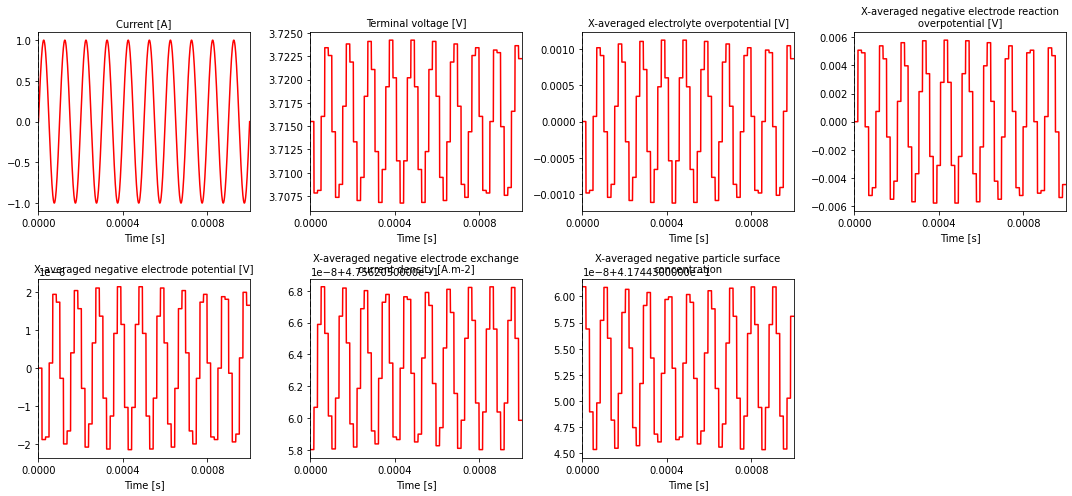

In [35]:
# Set drive cycle
freqs=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
ncycles=10
parameter_values["Lower voltage cut-off [V]"] = 2
parameter_values["Upper voltage cut-off [V]"] = 4.2
sims = []
mag=[]
phase=[]
RealZ=[]
ImagZ=[]
for f in freqs:


    parameter_values["Current function [A]"] = pybamm.sin(2*math.pi*f*timescale * pybamm.t)


    # load solvers
    safe_solver = pybamm.CasadiSolver(atol=1e-6, rtol=1e-6, mode="safe",dt_max=.05)
    #scikits_solver=pybamm.ScikitsOdeSolver(method='cvode',atol=1e-6, rtol=1e-9,extrap_tol=0.001)
    #model.set_soc_variables(),solver=safe_solver

    # get the spatial variables used in pybamm
    var = pybamm.standard_spatial_vars  

    # create our dictionary 
    var_pts = {
        var.x_n: 30,  # negative electrode
        var.x_s: 10,  # separator 
        var.x_p: 30,  # positive electrode
        var.r_n: 20,  # negative particle
        var.r_p: 20,  # positive particle
    }

    # Define HPPC
    #experiment = pybamm.Experiment(
    #    [
    #        ("Charge at 0.474 A for 720 seconds or until 4.2 V (1 second period)",
    #        "Rest for 60 seconds (1 second period)",
    #        "Rest for 1740 seconds (10 second period)",
    #        "Charge at 2.37 A for 10 seconds or until 4.2 V (0.1 second period)",
    #        "Rest for 60 seconds (1 second period)",
    #        "Rest for 540 seconds (10 second period)",
    #        "Discharge at 2.37 A for 10 seconds (0.1 second period)",
    #        "Rest for 60 seconds (1 second period)",
    #        "Rest for 540 seconds (10 second period)"
    #    ] * 3
    #)
    timetime=np.linspace(0,ncycles/f,ncycles*100+1)

    sim = pybamm.Simulation(model, parameter_values=parameter_values,solver=safe_solver,var_pts=var_pts)
    sim.solve(t_eval=timetime)
    sims.append(sim)

    time = sim.solution["Time [s]"].entries
    capacity = sim.solution["Discharge capacity [A.h]"](time)
    current = -sim.solution["Current [A]"](time)
    voltage = sim.solution["Terminal voltage [V]"](time)
    Cfft=fft(current)
    Vfft=fft(voltage)
    L=len(time)
    Ts=time[1]-time[0]
    #Fn=2/Ts
    Fv=fftfreq(L,Ts)# np.linspace(0,1,np.fix(L/2)+1)*Fn
# Ts = mean(diff(t));                                     % Calculate Foureir Transform
# Fs = 1/Ts;
# Fn = Fs/2;
# Fy = fft(y)/L;
# Fv = linspace(0, 1, fix(L/2)+1)*Fn;
# Iv = 1:length(Fv);
# aFy = abs(Fy(Iv))*2;
# ampHz = @(Hz) interp1(Fv, aFy, Hz, 'linear');           % Interpolation Anonymous Function
# amp60 = ampHz(60)                                       % Find Amplitude At 60 Hz
    Zfft=Vfft/Cfft
    threshold=np.amax(abs(Vfft))/10000
    small_vals=abs(Vfft)<threshold
    Zfft[small_vals]=0
    
    threshold=np.amax(abs(Cfft))/10000
    small_vals=abs(Cfft)<threshold
    Zfft[small_vals]=0

    MM=abs(Zfft)

    mag.append(np.interp(f,Fv,MM))

    phase_all=np.arctan2(np.imag(Zfft),np.real(Zfft))*180/np.pi
    phase.append(np.interp(f,Fv,phase_all))
    RealZ.append(np.imag(np.interp(f,Fv,Zfft)))
    ImagZ.append(np.real(np.interp(f,Fv,Zfft)))
#sim.solve([0,5000])
sim.plot(["Current [A]", "Terminal voltage [V]",'X-averaged electrolyte overpotential [V]','X-averaged negative electrode reaction overpotential [V]','X-averaged negative electrode potential [V]','X-averaged negative electrode exchange current density [A.m-2]','X-averaged negative particle surface concentration'])

array([-6.71823708e-14-0.j        , -3.16588294e-04+0.10087363j,
       -1.30584440e-03+0.20803669j, ..., -3.09923252e-03-0.3291579j ,
       -1.30584440e-03-0.20803669j, -3.16588294e-04-0.10087363j])

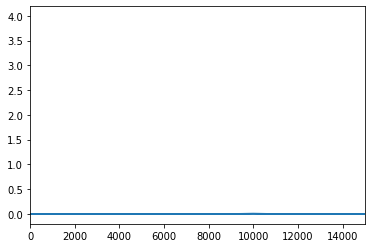

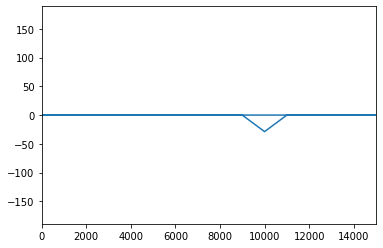

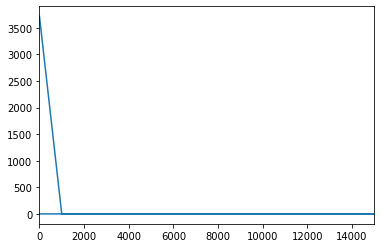

In [44]:
plt.figure(1)
plt.plot(Fv,MM)
plt.xlim([0, 1.5*f])
plt.figure(2)
plt.plot(Fv,phase_all)
plt.xlim([0, 1.5*f])
#Fv
#phase_all
#phase
#mag
#RealZ
Zfft=Vfft/Cfft
Zfft[0]=0
plt.figure(3)
plt.plot(Fv,Vfft)
plt.xlim([0, 1.5*f])
freqs
Zfft
Vfft
Cfft

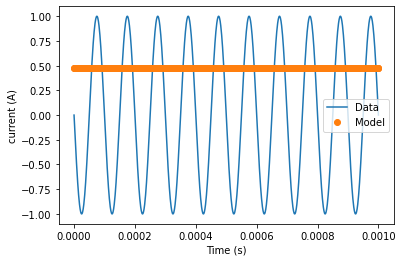

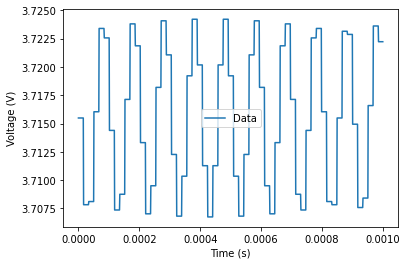

In [37]:
time = sim.solution["Time [s]"].entries
capacity = sim.solution["Discharge capacity [A.h]"](time)
current = -sim.solution["Current [A]"](time)
voltage = sim.solution["Terminal voltage [V]"](time)

#current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], -drive_cycle[:, 1], pybamm.t,interpolator="linear")
# timetime=np.linspace(0,10000,100000)
timecuurentplot=-current_interpolant.evaluate(timetime)

plt.figure(1)
# plt.scatter(C_rates, capacities)
#plt.plot(drive_cycle[:, 0], drive_cycle[:, 1],'.-', label = "Data")
plt.plot(time,current, label = "Model")
plt.plot(timetime,timecuurentplot,'o', label = "interpolant")

plt.xlabel('Time (s)')
plt.ylabel('current (A)')
#plt.xlim([0, 15000])
#plt.xlim([1799+720,1799+720+21 ])

plt.legend(['Data','Model','Interpolant'])
plt.figure(2)
#plt.plot(drive_cycle[:, 0], drive_cycle[:, 2],'.-', label = "Data")
plt.plot(time, voltage)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
#plt.xlim([0, 15000])
#plt.xlim([1799+720,1799+720+21 ])
#plt.ylim([3.2, 3.6])
plt.legend(['Data','Model'])
plt.show()



# axs[1].plot()
# #cxy, f = axs[1].cohere(s1, s2, 256, 1. / dt)
# axs[1].set_ylabel('Voltage (V)')

# fig.tight_layout()
# plt.show()